In [1]:
#|default_exp accel

Differences in this notebook:
 - mixed precision
 - eliminate DDPM as a callback by noisifying in the dataloader and using a slightly updated, more flexible Learner
 - use accelerator library to accomplish mixed precision

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dt = dls.train
xb,yb = next(iter(dt))

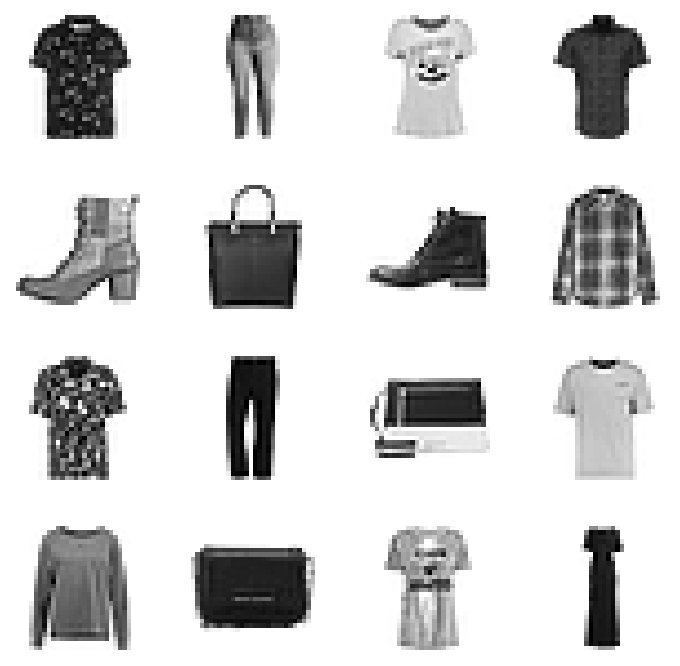

In [6]:
show_images(xb[:16])

In [9]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [7]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [10]:
(xt, t), noise = noisify(xb[:16], alphabar)

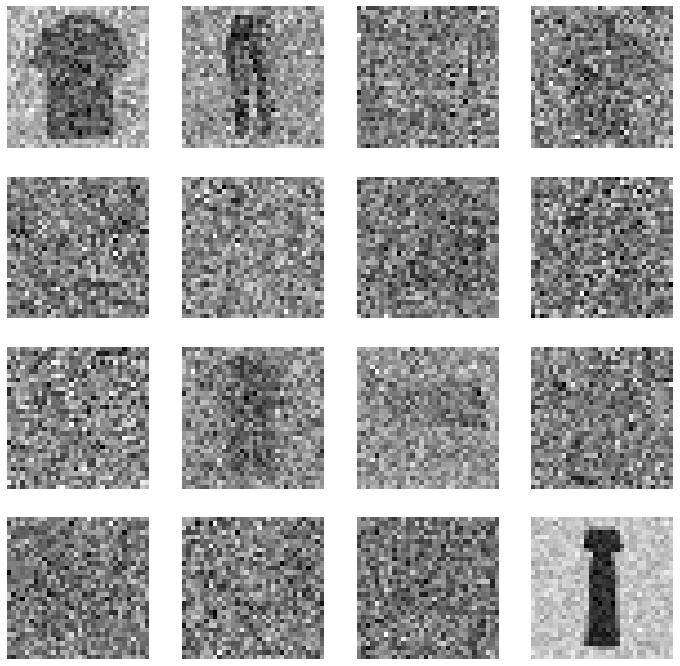

In [14]:
show_images(xt)

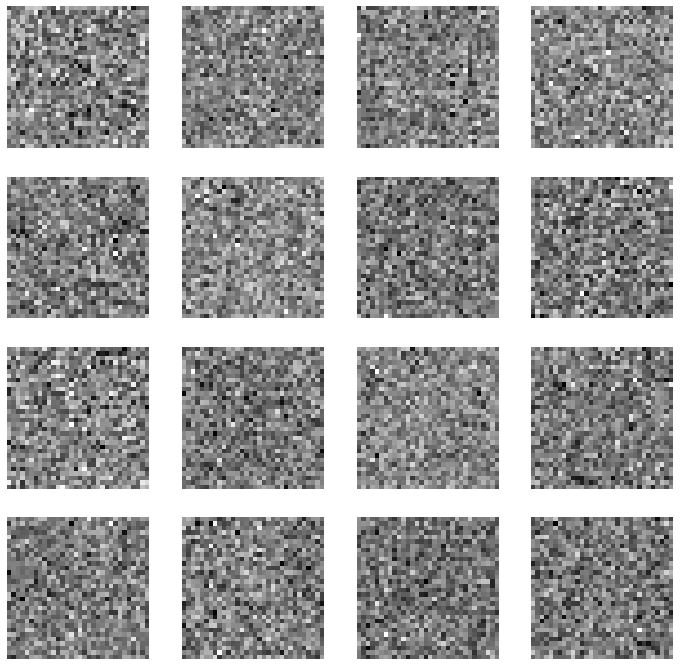

In [16]:
show_images(noise)

In [19]:
from diffusers import UNet2DModel

0it [00:00, ?it/s]

In [17]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [20]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [21]:
def collate_ddpm(b):
    return noisify(default_collate(b)[xl], alphabar)

def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [23]:
'''
tds stands for transformed dataset. ds is the raw dataset, tds is after images are formatted into tensors
(and padded in this case)
'''
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [24]:
#|export 
class MixedPrecision(TrainCB):
    order = DeviceCB.order + 10
    
    def before_fit(self, learn):
        self.scaler = torch.cuda.amp.GradScaler()
        
    def before_batch(self, learn):
        self.autocast = torch.autocast('cuda', dtype=torch.float16)
        self.autocast.__enter__()
    
    def after_loss(self, learn):
        self.autocast.__exit__(None, None, None)
    
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()
    
    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()


In [26]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [28]:
opt_func = partial(optim.Adam, eps=1e-5)

In [32]:
bs=512

In [33]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

## Accelerator

In [35]:
! pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 11.6 MB/s eta 0:00:00


In [36]:
#|export
from accelerate import Accelerator

In [40]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order + 10
    
    def __init__(self, n_inp=1, mixed_precision='fp16'):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
    
    def before_fit(self, learn):
        (learn.model, learn.opt, learn.dls.train, learn.dls.valid) = self.acc.prepare(
        learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def backward(self, learn):
        self.acc.backward(learn.loss)

In [41]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [68]:
clean_mem()

In [ ]:
bs=750

dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)

## trick: repeat batches

In [66]:
class MultDL:
    def __init__(self, dl, mult=2):
        self.dl=dl
        self.mult=mult
    
    def __len__(self):
        return len(self.dl) * self.mult
    
    def __iter__(self):
        for o in self.dl:
            for z in range(self.mult):
                yield o

loss,epoch,train
0.175,0,train
0.028,0,eval


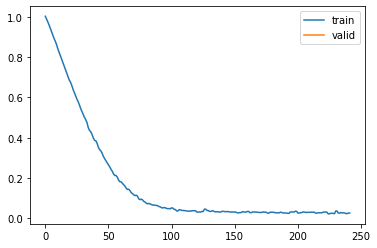

KeyboardInterrupt: 

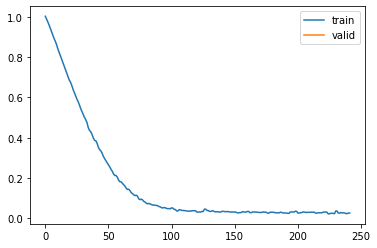

In [71]:
clean_mem()
bs=512

dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))
dls.train = MultDL(dls.train)

class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

learn.fit(epochs)

In [ ]:
import nbdev; nbdev.nbdev_export()